**Install and import dependencies**


In [1]:
from obspy import read
import matplotlib.pyplot as plt
import torch
from preprocessing import to3dArray, pad_or_crop_3d_array

**Ensure CUDA is enabled for hardware accelerated training**

In [2]:
from warnings import warn
if not torch.cuda.is_available():
    warn("No hardware acceleration is being used. Install CUDA or ensure the runtime type is set to GPU if using google colab")
else:
    print("Torch with CUDA is enabled")

Torch with CUDA is enabled


**Replace SGY_PATH with the path to the SEGY file in the mounted google drive account**

In [3]:
SGY_PATH = "./SeismicData/Netherlands.sgy"

stream = read(SGY_PATH, format="SEGY")

stream.normalize()

seismic_array = to3dArray(stream)

In [13]:
sample_depth = len(stream[0].data)


def get_xy(trace):
    header = trace.stats.segy.trace_header


    x_bytes = header.unpacked_header[73:76]
    y_bytes = header.unpacked_header[77:80]

    return int.from_bytes(x_bytes, byteorder="<" if header.endian=="little" else "big"), int.from_bytes(y_bytes, byteorder="<" if header.endian=="little" else "big")

def get_max_xy(stream):
    maxXVal = float("-inf")
    maxYVal = float("-inf")
    for trace in stream:
        x_val, y_val = get_xy(trace)
        if x_val > maxXVal:
            maxXVal = x_val
        if y_val > maxYVal:
            maxYVal = y_val
    return maxXVal, maxYVal



def get_min_xy(stream):
    maxXVal = float("inf")
    maxYVal = float("inf")
    for trace in stream:
        x_val, y_val = get_xy(trace)
        if x_val < maxXVal:
            maxXVal = x_val
        if y_val < maxYVal:
            maxYVal = y_val
    return maxXVal, maxYVal





max_x, max_y = get_max_xy(stream)
min_x, min_y = get_min_xy(stream)


print(max_x-min_x)
print(max_y-min_y)
print(stream)
print(get_xy(stream[0]))




241596
169068
600515 Trace(s) in Stream:

Seq. No. in line:    1 | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:01.844000Z | 250.0 Hz, 462 samples
...
(600513 other traces)
...
Seq. No. in line:  577 | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:01.844000Z | 250.0 Hz, 462 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]
(6058355, 10403916)


**Normalize all amplitude values from -1 to 1 for model interpretation**

**Calculate number of inlines and crosslines measured**

**Convert into Numpy array with axes as (depth, crossline, inline)**

Text(0, 0.5, 'Depth')

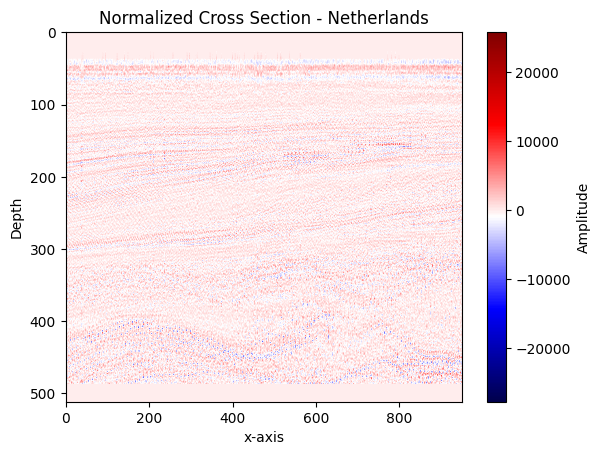

In [16]:

cube = pad_or_crop_3d_array(seismic_array, (512, 512, 512))


example_inline_number = int(len(cube)/2)

plt.imshow(cube[example_inline_number], cmap="seismic", aspect="auto")
plt.colorbar(label="Amplitude")
plt.title("Normalized Cross Section - Netherlands")
plt.xlabel("x-axis")
plt.ylabel("Depth")

In [ ]:
import torch.nn as nn


class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d
        